We'll need to create some ratings for the recommender to work off of, as we should be able to get better ratings with an explicit rating per song.

We should be able to get a rating by changing the amount of times someone has listened to a song with rating.

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 

In [3]:
drive.mount('/drive')

Mounted at /drive


In [4]:
listens=pd.read_csv('/drive/My Drive/Colab Notebooks/listen_table.csv')

In [ ]:
listens.head()

,Unnamed: 0,user_name,song_no
0,0,Skeebadoo,0
1,1,Skeebadoo,1
2,2,Skeebadoo,2
3,3,Skeebadoo,3
4,4,Svarthjelm,4


In [ ]:
listens.columns

Index(['Unnamed: 0', 'user_name', 'song_no'], dtype='object')

In [5]:
listens.drop(columns=['Unnamed: 0'], inplace=True)
listens.head()

,user_name,song_no
0,Skeebadoo,0
1,Skeebadoo,1
2,Skeebadoo,2
3,Skeebadoo,3
4,Svarthjelm,4


In [6]:
# create a ratings col by the amount of plays
# give every listen a listen_count of 1
listens['listen_no'] = 1
listens.head()

,user_name,song_no,listen_no
0,Skeebadoo,0,1
1,Skeebadoo,1,1
2,Skeebadoo,2,1
3,Skeebadoo,3,1
4,Svarthjelm,4,1


In [7]:
df2 = listens.groupby(["user_name","song_no"], sort=False, as_index=False).agg({"listen_no":"sum"})
df2.head()

,user_name,song_no,listen_no
0,Skeebadoo,0,3
1,Skeebadoo,1,1
2,Skeebadoo,2,2
3,Skeebadoo,3,1
4,Svarthjelm,4,10


In [ ]:
len(listens)

37775007

In [ ]:
len(df2)

12819261

By combining the plays per song per profile, we've been able to condense our data to 12 million rows. Lets take a look at the listen no distribution to see what would be a good way to create a rating from the plays.

Text(0.5, 1.0, 'Frequency of Number of Plays')

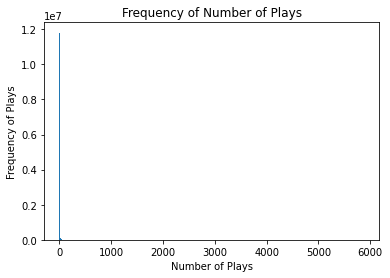

In [9]:
df2['listen_no'].plot.hist(bins=1000)
plt.xlabel('Number of Plays')
plt.ylabel('Frequency of Plays')
plt.title('Frequency of Number of Plays')

In [10]:
df2['listen_no'].describe()

count    1.281926e+07
mean     2.946738e+00
std      9.564659e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.874000e+03
Name: listen_no, dtype: float64

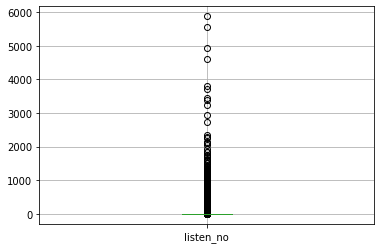

In [11]:
df2.boxplot(column='listen_no')

In [12]:
# cap max listens to 100 for analysis
df2['listen_no_aug'] = df2['listen_no']
mask = df2['listen_no'] > 100
column_name = 'listen_no_aug'
df2.loc[mask, column_name] = 100

Text(0.5, 1.0, 'Frequency of Number of Plays')

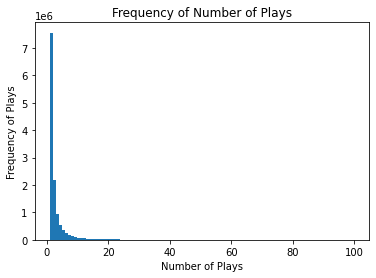

In [14]:
df2['listen_no_aug'].plot.hist(bins=100)
plt.xlabel('Number of Plays')
plt.ylabel('Frequency of Plays')
plt.title('Frequency of Number of Plays')

In [ ]:
df2['listen_no_aug'].describe()

count    1.281926e+07
mean     2.871603e+00
std      6.023958e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.000000e+02
Name: listen_no_aug, dtype: float64

In [ ]:
df2.head()

,user_name,song_no,listen_no,listen_no_aug
0,Skeebadoo,0,3,NaN
1,Skeebadoo,1,1,NaN
2,Skeebadoo,2,2,NaN
3,Skeebadoo,3,1,NaN
4,Svarthjelm,4,10,NaN


### Analysis

Nearly all of the time, a song is listened to only a single time. There are a very small amount of people who will listen to a song thousands of times.(almost 6000 max plays!)

We're going to use a bit of inference here to decide what rating should entail. A 'listen' from the original data is only registered if the song is played for more than half of it's length or for 4 minutes, whichever comes first. I'll assume that if someone is willing to sit through a whole 'listen', then they must at least marginally enjoy it.

This will affect our recommendations because there will be no 'negative' ratings, only positive ratings.

We'll set the ratings as seen below for now, and then may revisit these ratings later if we have time.

In [ ]:
listens = listens.groupby(["user_name","song_no"], sort=False, as_index=False).agg({"listen_no":"sum"})
listens.head()

,user_name,song_no,listen_no
0,Skeebadoo,0,3
1,Skeebadoo,1,1
2,Skeebadoo,2,2
3,Skeebadoo,3,1
4,Svarthjelm,4,10


In [ ]:
# Minimum rating = 3
listens['rating'] = 3

# 75%: 2 listens. rating = 4
listens.loc[listens['listen_no'] == 2, 'rating'] = 4

# 75%+: >2 listens. rating = 5
listens.loc[listens['listen_no'] > 2, 'rating'] = 5

In [ ]:
listens.head()

,user_name,song_no,listen_no,rating
0,Skeebadoo,0,3,5
1,Skeebadoo,1,1,3
2,Skeebadoo,2,2,4
3,Skeebadoo,3,1,3
4,Svarthjelm,4,10,5


In [ ]:
listens.drop(columns = ['listen_no'], inplace=True)
listens.head()

,user_name,song_no,rating
0,Skeebadoo,0,5
1,Skeebadoo,1,3
2,Skeebadoo,2,4
3,Skeebadoo,3,3
4,Svarthjelm,4,5


In [ ]:
# We'll save this now to gridsearch in another notebook
listens.to_csv('/drive/My Drive/Colab Notebooks/rated_listens.csv')